# GCOM-C L2

Here I'm going to download GCOM-C LST (land surface temperature) L2 data around Vietnam area from G-Portal via FTP, display them, and calculate its statistical values.

In [1]:
import os
import math
from osgeo import gdal

## Connect to FTP server

In [5]:
from dotenv import load_dotenv
load_dotenv()
username = os.getenv('FTP_USERNAME')

from ftplib import FTP
ftp = FTP('ftp.gportal.jaxa.jp')
ftp.login(username, 'anonymous');

In [4]:
ftp.dir()

drwxr-xr-x   5 3498     3498         4096 May 29  2018 nrt
drwxr-xr-x 331 3498     3498       131072 Nov 13 19:25 order
drwxr-xr-x 1655 3498     3498       131072 Nov 10 14:01 process
drwxr-xr-x  17 3498     3498         4096 Mar 18  2020 standard


## Download 8day statistical data

In [6]:
def download(year: int, month: int, tile: (int, int)):
    base = 'downloads'

    dir = "standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/{:d}/{:02d}".format(year, month)
    os.makedirs(os.path.join(base, dir), exist_ok=True)

    filenames = [filename for filename, _ in ftp.mlsd(dir) if "08D_T{:02d}{:02d}".format(*tile) in filename]
    for filename in filenames:
        filepath = os.path.join(base, dir, filename)
        if os.path.exists(filepath):
            continue
        with open(filepath, 'wb') as f:
            ftp.retrbinary(f"RETR /{dir}/{filename}", f.write)
    return [os.path.join(dir, filename) for filename in filenames]

In [7]:
downloaded = download(2023, 10, (8, 28))
downloaded

['standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/GC1SG1_20231008D08D_T0828_L2SG_LST_Q_3000.h5',
 'standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/GC1SG1_20231008A08D_T0828_L2SG_LST_Q_3000.h5',
 'standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/GC1SG1_20231016D08D_T0828_L2SG_LST_Q_3000.h5',
 'standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/GC1SG1_20231016A08D_T0828_L2SG_LST_Q_3000.h5',
 'standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/GC1SG1_20231024D08D_T0828_L2SG_LST_Q_3000.h5',
 'standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/GC1SG1_20231024A08D_T0828_L2SG_LST_Q_3000.h5']

## Translate and wrap into GeoTiff

In [9]:
r = 6371000 # radius of the earth
d = 0.017453292519943295 # degree

def translate(filename: str):
    ds = gdal.Open(os.path.join('downloads', filename), gdal.GA_ReadOnly)
    md = ds.GetMetadata()
    (upper_left_lng, upper_left_lat) = (
        float(md['Geometry_data_Upper_left_longitude']),
        float(md['Geometry_data_Upper_left_latitude'])
    )
    (lower_right_lng, lower_right_lat) = (
        float(md['Geometry_data_Lower_right_longitude']),
        float(md['Geometry_data_Lower_right_latitude'])
    )
    upper_left_projected  = (r * d * upper_left_lng  * math.cos(upper_left_lat  * math.pi / 180), r * d * upper_left_lat)
    lower_right_projected = (r * d * lower_right_lng * math.cos(lower_right_lat * math.pi / 180), r * d * lower_right_lat)

    image_ds = gdal.Open(ds.GetSubDatasets()[0][0], gdal.GA_ReadOnly)
    image_ds.GetRasterBand(1).SetScale(0.02)
    image_ds.GetRasterBand(1).SetOffset(0)

    output_dir = os.path.join('output', os.path.dirname(filename))
    os.makedirs(output_dir, exist_ok=True)
    gdal.Translate(
        os.path.join('output', os.path.splitext(filename)[0] + '.translated' + '.tif'),
        image_ds,
        format="GTiff",
        outputSRS="ESRI:53008",
        outputBounds=[*upper_left_projected, *lower_right_projected],
        noData=65535,
        creationOptions=['COMPRESS=LZW'])

In [10]:
def warp(filename: str):
    gdal.Warp(
        os.path.join('output', os.path.splitext(filename)[0] + '.warped' + '.tif'),
        os.path.join('output', os.path.splitext(filename)[0] + '.translated' + '.tif'),
        dstSRS='EPSG:4326'
    )

In [11]:
for filename in downloaded:
    translate(filename)
    warp(filename)

In [22]:
ds = gdal.Open('output/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/GC1SG1_20231008D08D_T0828_L2SG_LST_Q_3000.warped.tif', gdal.GA_ReadOnly)
ds.GetRasterBand(1).GetMetadata()

{'Image_data_LST_AVE_Data_description': 'Average of LST parameter (temporal statistics)',
 'Image_data_LST_AVE_Error_DN': '65535 ',
 'Image_data_LST_AVE_Maximum_valid_DN': '65534 ',
 'Image_data_LST_AVE_Minimum_valid_DN': '0 ',
 'Image_data_LST_AVE_Offset': '0 ',
 'Image_data_LST_AVE_Slope': '0.02 ',
 'Image_data_LST_AVE_Unit': 'Kelvin'}

## Merge the multiple files from different area into one

In [2]:
import glob

def group(year: int, month: int):
    grouped = dict()
    target_dir = 'output/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/{:d}/{:02d}'.format(year, month)
    for filepath in glob.glob(os.path.join(target_dir, '*.warped.tif')):
        date_and_path = os.path.basename(filepath).split('_')[1]
        if date_and_path in grouped:
            grouped[date_and_path].append(filepath)
        else:
            grouped[date_and_path] = [filepath]
    return grouped

In [3]:
grouped = group(2023, 10)

from pprint import pprint
for k, v in grouped.items():
    print(k)
    pprint(v)

20231024D08D
['output/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/GC1SG1_20231024D08D_T0727_L2SG_LST_Q_3000.warped.tif',
 'output/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/GC1SG1_20231024D08D_T0828_L2SG_LST_Q_3000.warped.tif',
 'output/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/GC1SG1_20231024D08D_T0728_L2SG_LST_Q_3000.warped.tif',
 'output/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/GC1SG1_20231024D08D_T0627_L2SG_LST_Q_3000.warped.tif']
20231016D08D
['output/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/GC1SG1_20231016D08D_T0627_L2SG_LST_Q_3000.warped.tif',
 'output/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/GC1SG1_20231016D08D_T0728_L2SG_LST_Q_3000.warped.tif',
 'output/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/GC1SG1_20231016D08D_T0828_L2SG_LST_Q_3000.warped.tif',
 'output/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/GC1SG1_20231016D08D_T

In [4]:
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.merge import merge as rmerge

In [8]:
def merge(key, filenames):
    output_filepath = os.path.join(os.path.dirname(filenames[0]), key + '.merged.tif')
    if os.path.exists(output_filepath):
        return output_filepath
    
    merged, transform = rmerge(filenames)
    with rio.open(filenames[0]) as src:
        out_band1_tags = src.tags(1).copy()
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": merged.shape[1],
            "width": merged.shape[2],
            "transform": transform
        })
    
    with rio.open(output_filepath, "w", **out_meta) as output:
        output.write(merged)
    return output_filepath

In [6]:
merged = list()
for k, v in grouped.items():
    filepath = merge(k, v)
    merged.append(filepath)
merged

['output/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/20231024D08D.merged.tif',
 'output/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/20231016D08D.merged.tif',
 'output/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/20231008D08D.merged.tif',
 'output/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/20231016A08D.merged.tif',
 'output/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/20231024A08D.merged.tif',
 'output/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10/20231008A08D.merged.tif']

### Display (for debugging)

In [ ]:
import glob
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 9))

filenames = glob.glob(os.path.join('output/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10', '*.merged.tif'))
for idx, m in enumerate(filenames):
    ax = plt.subplot(1, len(filenames), idx+1)
    show(rio.open(m), ax=ax)

## Mask with AoI

In [7]:
import glob
import fiona
import rasterio as rio
from rasterio import plot
from rasterio.plot import show
from rasterio.mask import mask as rmask

In [9]:
def mask(filepath: str):
    output_filepath = os.path.join(os.path.dirname(filepath), os.path.basename(filepath).split('.')[0] + '.masked.tif')
    # if os.path.exists(output_filepath):
    #     return output_filepath
    
    with fiona.open('vietnam_country.geojson', 'r') as mask:
      masks = [feature['geometry'] for feature in mask]
    
    with rio.open(filepath) as src:
      out_image, out_transform = rmask(src, masks, crop=True)
      out_meta = src.meta
    
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })
    
    with rio.open(output_filepath, 'w', **out_meta) as dest:
      dest.write(out_image)
    
    return output_filepath

In [10]:
filenames = glob.glob(os.path.join('output/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10', '*.merged.tif'))
output_filepaths = [mask(filename) for filename in filenames]

### Display (for debugging)

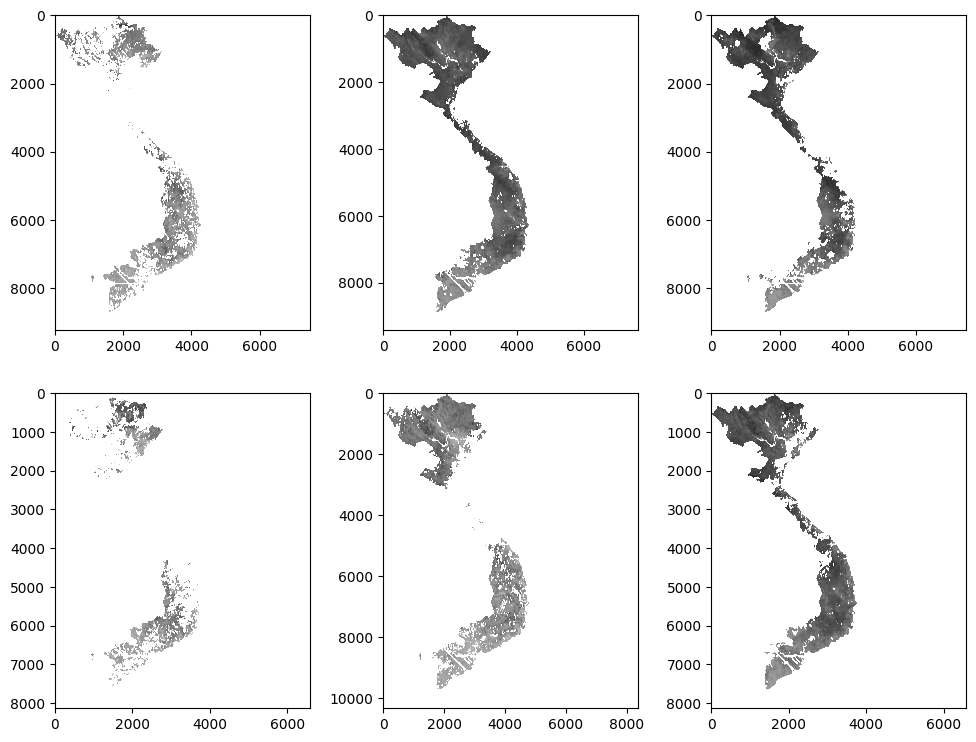

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 3, figsize=(12, 9))

filenames = glob.glob(os.path.join('output/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.LST_.Statistics/3/2023/10', '*.masked.tif'))
for idx, m in enumerate(filenames):
    dataset = gdal.Open(m, gdal.GA_ReadOnly)
    band = dataset.GetRasterBand(1)
    band.SetScale(0.02)
    band.SetOffset(0)
    row, col = int(idx / 3), idx % 3
    arr = band.ReadAsArray()
    ax[row, col].imshow(arr, vmin=13600, vmax=16400, cmap='gray')

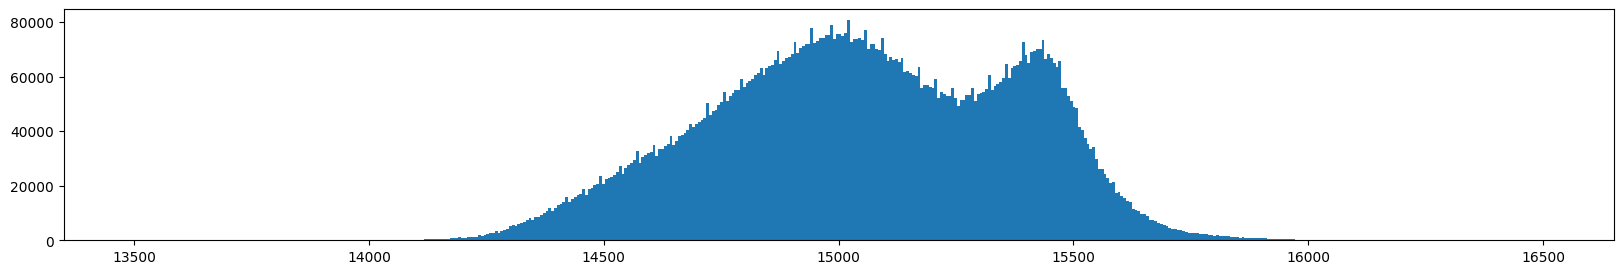

In [60]:
dataset = gdal.Open(filenames[4], gdal.GA_ReadOnly)
band = dataset.GetRasterBand(1)
band.SetScale(0.02)
band.SetOffset(0)
# band.GetNoDataValue()
arr = band.ReadAsArray()
plt.figure(figsize=(20,3))
plt.hist(arr.flatten(),bins=500,range=(13500, 16500)) 
plt.show()

In [61]:
import pandas as pd
arr = arr[arr < 65534] * 0.02 - 273.15
pd.DataFrame(pd.Series(arr.ravel()).describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
0,10637647.0,27.94297,6.361279,2.81,23.39,27.89,33.21,62.13


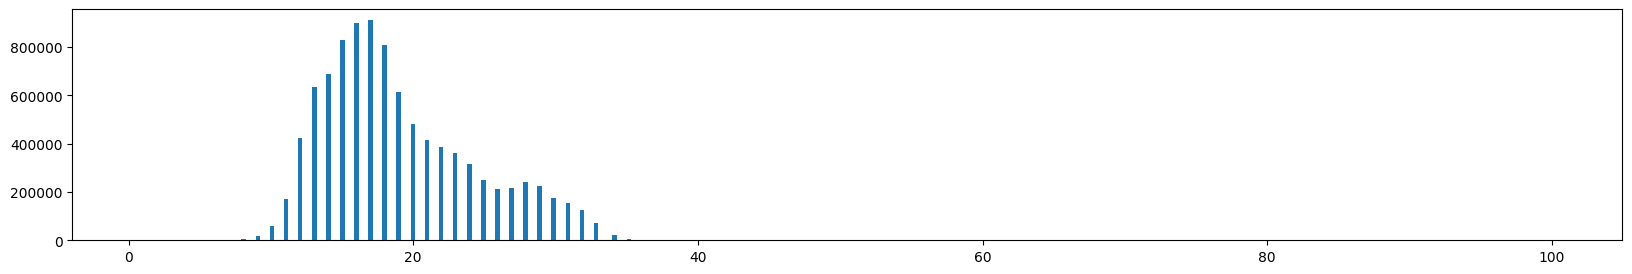

In [48]:
dataset = gdal.Open(filenames[1], gdal.GA_ReadOnly)
band = dataset.GetRasterBand(1)
band.SetScale(0.02)
band.SetOffset(0)
# band.GetNoDataValue()
arr = band.ReadAsArray()
plt.figure(figsize=(20,3))
plt.hist(arr.flatten(),bins=300,range=(1, 100)) 
plt.show()